In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar
import numpy as np
from scipy.integrate import quad
import scipy.stats as stat
from scipy.special import erfc, erf

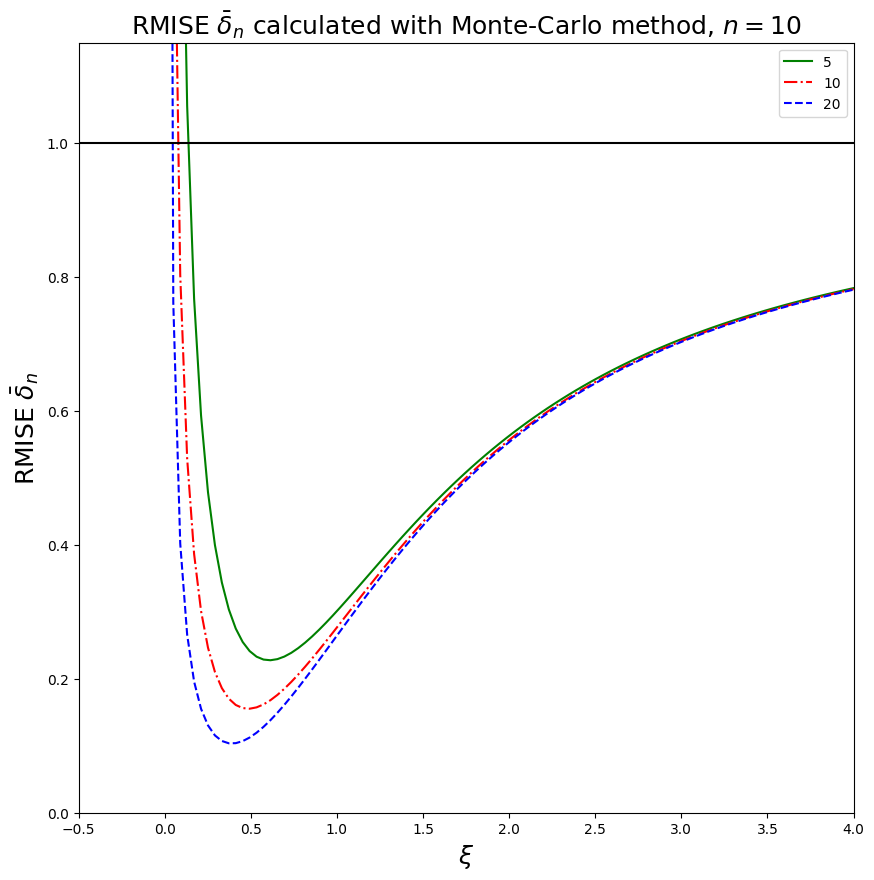

In [2]:
def delta(x,n):
    return 1 + 1/n * (2/3)**0.5 / x + (1-1/n) * np.exp(-2*6**0.5*x)*(2*6**0.5*x+np.exp(2*6**0.5*x)*(4*6**0.5*x-3)+3)/(12*x*x) - 2 * (2 - np.exp(-6**0.5*x) * (6**0.5*x+2))/(x*6**0.5)


x_min = 0.01
x_max = 4
n = [5,10,20]
x = np.linspace(x_min, x_max, 100)
d = []
for n_i in n:
    d.append(delta(x,n_i))
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(x, d[0],"g-", x, d[1], "r-.", x, d[2], "b--")
ax.legend(n)
ax.plot([-1, x_max+1], [1, 1], 'k-')
ax.set_xlim([-0.5, x_max])
ax.set_ylim([0, 1.15])
ax.set_title(r"RMISE $\bar{\delta}_n$ calculated with Monte-Carlo method, $n=10$",fontsize=18)
ax.set_xlabel(r"$\xi$",fontsize=18)
ax.set_ylabel(r"RMISE $\bar{\delta}_n$",fontsize=18)
plt.show()
# print(x[6], d[2][6])

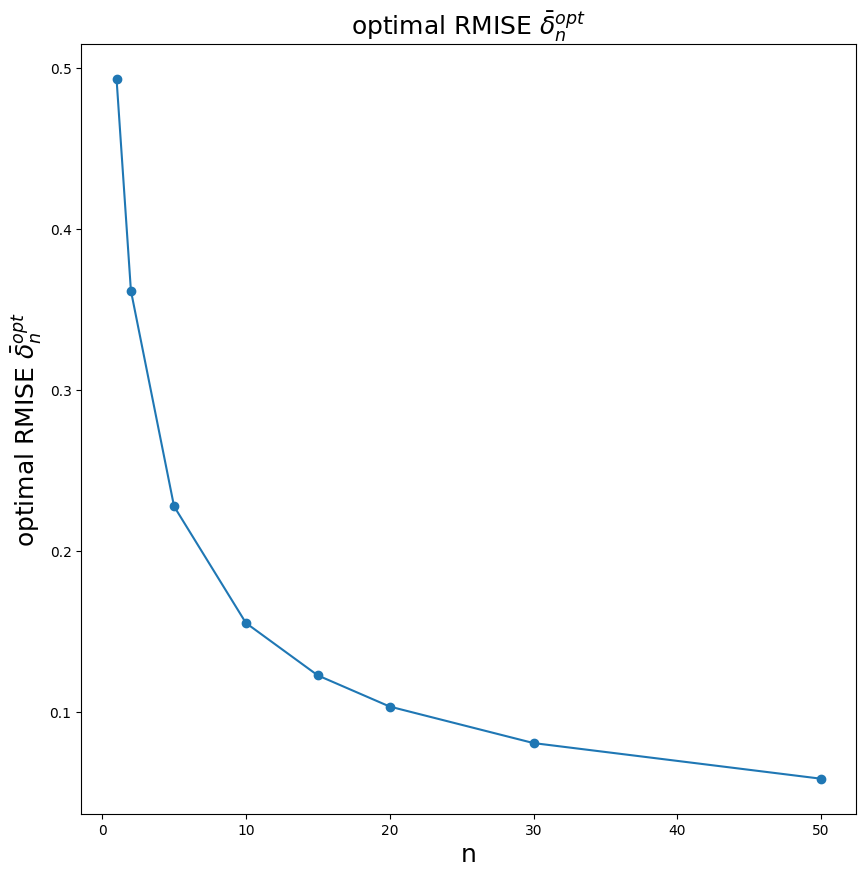

In [30]:
n = np.array([1,2,5,10,15,20,30,50], dtype=float)
delta_opt = [minimize_scalar(delta, args=(n_i),bounds=(1e-5, 1e1)).fun for n_i in n]


fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(n,delta_opt,"-o")
ax.set_xlabel(r"n",fontsize=18)
ax.set_ylabel(r"optimal RMISE $\bar{\delta}_n^{opt}$ ",fontsize=18)
ax.set_title(r"optimal RMISE $\bar{\delta}_n^{opt}$",fontsize=18)

plt.show()

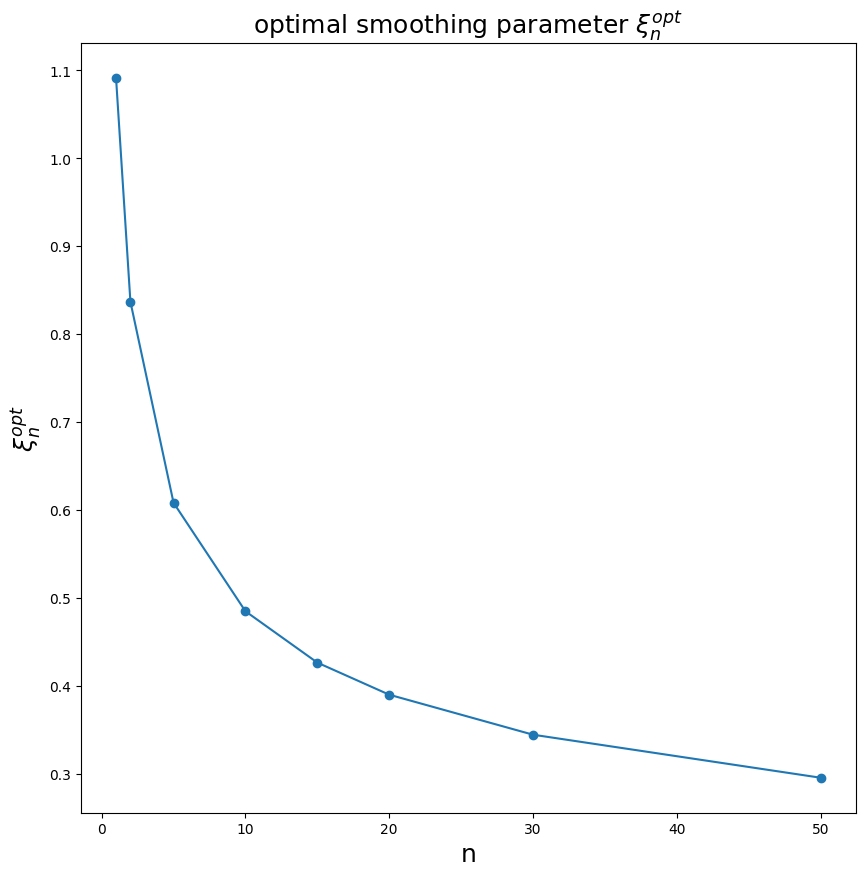

In [31]:
n = np.array([1,2,5,10,15,20,30,50], dtype=float)
delta_opt = [minimize_scalar(delta, args=(n_i),bounds=(1e-5, 1e2)).x for n_i in n]


fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(n,delta_opt,"-o")
ax.set_xlabel(r"n",fontsize=18)
ax.set_ylabel(r"$\xi_n^{opt}$",fontsize=18)
ax.set_title(r"optimal smoothing parameter $\xi_n^{opt}$",fontsize=18)

plt.show()

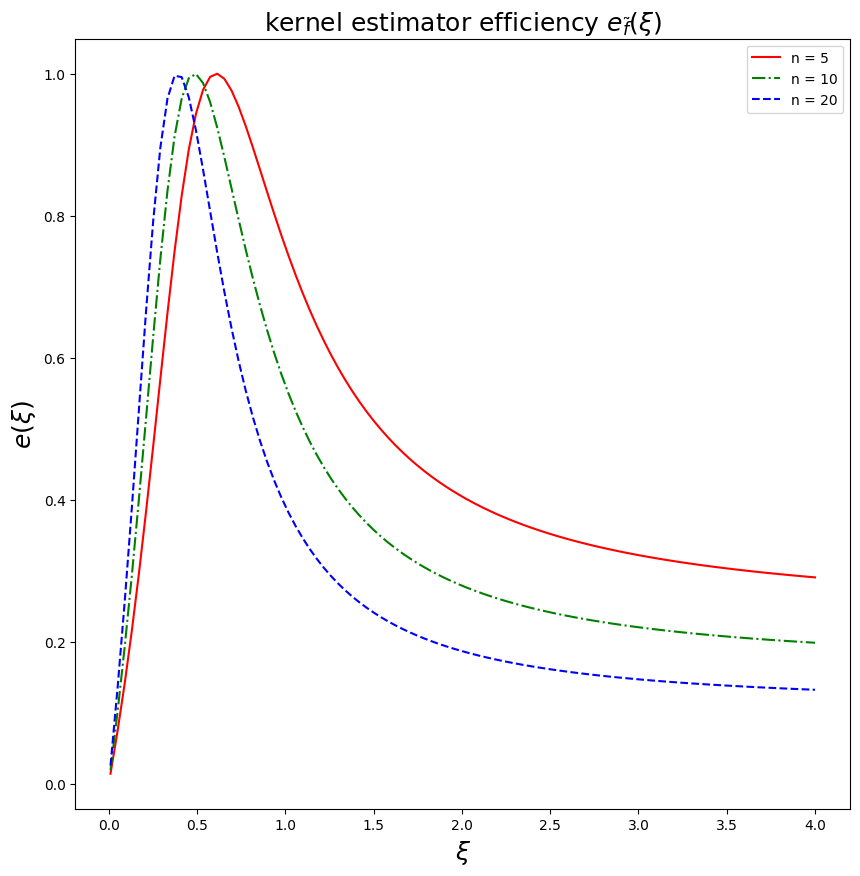

In [4]:
n = [5,10,20]
delta_opt = [minimize_scalar(delta, args=(n_i),bounds=(1e-5, 1e2)).fun for n_i in n]

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, delta_opt[0] / delta(x,n[0]),"r-",
        x, delta_opt[1] / delta(x,n[1]),"g-.",
        x, delta_opt[2] / delta(x,n[2]),"b--")

ax.set_xlabel(r"$\xi$",fontsize=18)
ax.set_ylabel(r"$e(\xi)$",fontsize=18)
ax.set_title(r"kernel estimator efficiency $e_{\tilde{f}}(\xi)$",fontsize=18)
ax.legend([f"n = {x}" for x in n])
plt.show()

In [4]:
import decimal
import functools
decimal.getcontext().prec = 400

@functools.lru_cache
def fact(n):
    return n * fact(n-1) if n >= 2 else decimal.Decimal(1)


def f(x,n):
    x = decimal.Decimal(x)
    n = decimal.Decimal(n)
    n2_1 = decimal.Decimal(2*n-1)
    fac = fact(n2_1)
    return decimal.Decimal(32)*n*n/fac * \
        decimal.Decimal(x**(2*n)) / decimal.Decimal((x+2*n)**3) * np.exp(-x)

def delta_ml(n):
    I = quad(f,0,np.inf,args=(n))[0]
    return 1 - 2 *I + 2*n/(2*n-1)

n = [1,2,3,5,7,10,15,20,30,40,50]
delta_ml_opt = np.array([delta_ml(n_i) for n_i in n])
delta_opt_kernel = [minimize_scalar(delta, args=(n_i),bounds=(1e-5, 1e3)).fun for n_i in n]


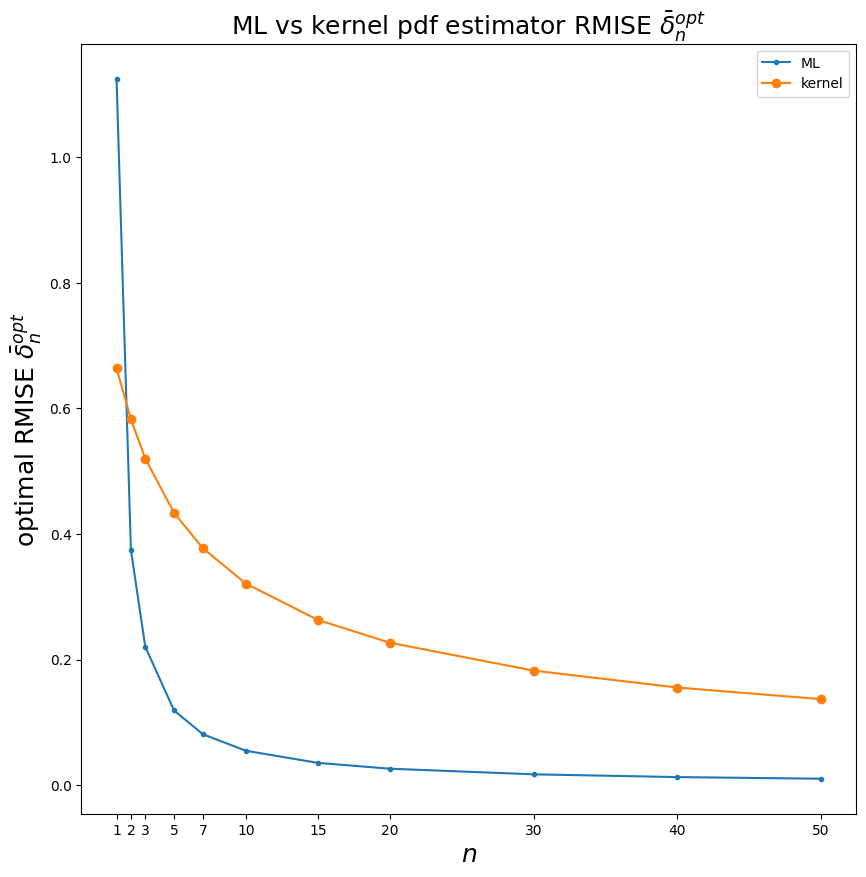

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(n, delta_ml_opt,".-", n, delta_opt_kernel, "o-")
ax.legend(["ML", "kernel"])
ax.set_title(r"ML vs kernel pdf estimator RMISE $\bar{\delta}_n^{opt}$",fontsize=18)
ax.set_xlabel(r"$n$",fontsize=18)
ax.set_ylabel(r"optimal RMISE $\bar{\delta}_n^{opt}$",fontsize=18)
ax.set_xticks(n)
plt.show()

In [3]:
def kern(x):
    return 1/(2*3**0.5) if np.abs(x) < 3**0.5 else 0

def f0(x):
    return 2 * x * np.exp(-2**0.5*x) if x >= 0 else 0

def f_square(x,n,xi,sample):
    return (f0(x) - 1/(n*xi) * np.sum([kern((x-sample[i])/xi) for i in range(np.shape(sample)[0])]))**2

def delta_mc_2(x,n,data):
    return 2*3**0.5 * quad(f_square,-np.inf,np.inf,args=(n,x,data))[0]

x_min = 0.01
x_max = 4
N = [10,50,500]
x = np.linspace(x_min, x_max, 100)

d = []
n = 10
for N_i in N:
    d_k = np.zeros(np.shape(x)[0])
    for i in range(np.shape(x)[0]):
        for j in range(N_i):
            sample = stat.gamma.rvs(a=2,scale=2**(-0.5),size=n)
            d_k[i] += 1/N_i * delta_mc_2(x[i], n, sample)
    d.append(d_k)
np.savetxt("delta_plot.txt",np.array(d))

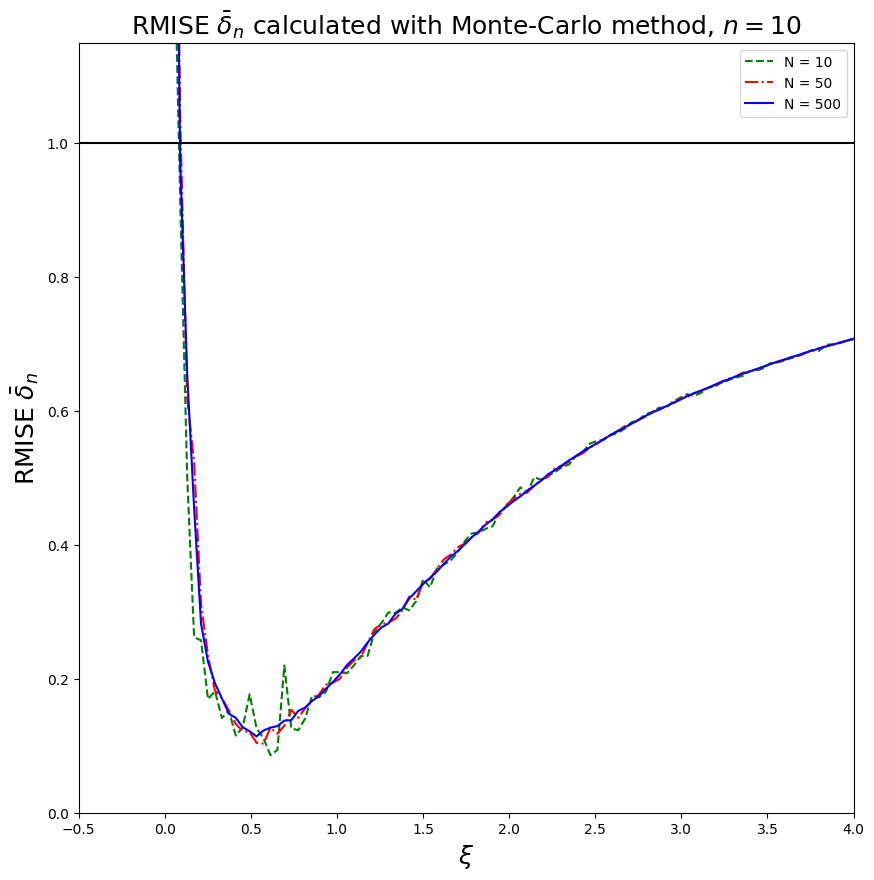

In [33]:
x_min = 0.01
x_max = 4
n = 10
d = np.loadtxt("delta_plot.txt")
x = np.linspace(x_min, x_max, 100)
N = [10, 50, 500]
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(x, d[0],"g--", x, d[1], "r-.", x,d[3],"b-", )
ax.legend([f"N = {N_i}" for N_i in N])
ax.plot([-1, x_max+1], [1, 1], 'k-')
ax.set_xlim([-0.5, x_max])
ax.set_ylim([0, 1.15])
ax.set_title(r"RMISE $\bar{\delta}_n$ calculated with Monte-Carlo method, $n=10$",fontsize=18)
ax.set_xlabel(r"$\xi$",fontsize=18)
ax.set_ylabel(r"RMISE $\bar{\delta}_n$",fontsize=18)
plt.show()

In [4]:
n = 20
x = 0.4
N= 1000
hist = np.zeros(N)
for j in range(N):
    sample = stat.gamma.rvs(a=2,scale=2**(-0.5),size=n)
    hist[j] = delta_mc_2(x, n, sample)
np.savetxt("hist_res.txt",np.array(hist))

/tmp/ipykernel_21350/3378085425.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 2*3**0.5 * quad(f_square,-np.inf,np.inf,args=(n,x,data))[0]


0.12086861920114993
0.0032363364247277883


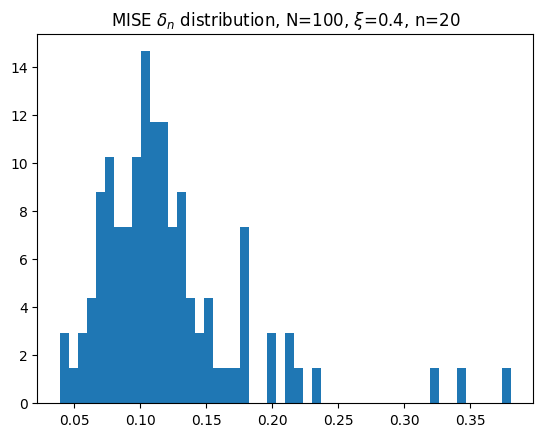

In [5]:
hist = np.loadtxt("hist_res.txt")
plt.hist(hist,density=True,bins=50)
plt.title(rf"MISE $\delta_n$ distribution, N={N}, $\xi$={x}, n={n}")
print(hist.mean())
print(hist.var())

In [ ]:
x_min = 0.01
x_max = 4
N = 1000
x = np.linspace(x_min, x_max, 100)

d = []
n = [1,2,5,10,20,50]
for n_i in n:
    d_k = np.zeros(np.shape(x)[0])
    for i in range(np.shape(x)[0]):
        for j in range(N):
            sample = stat.gamma.rvs(a=2,scale=2**(-0.5),size=n_i)
            d_k[i] += 1/N * delta_mc_2(x[i], n_i, sample)
    d.append(d_k)
np.savetxt("opt_plot.txt",np.array(d))

In [21]:
x_min = 0.01
x_max = 4
n = [1,2,5,10,20,50]
x = np.linspace(x_min, x_max, 100)
d = np.loadtxt("opt_plot.txt")

ii = []
xx_opt = []
d_opt = []

for j in range(len(n)):
    i_min, d_min, x_min = 0, np.infty, 0
    for i in range(np.shape(x)[0]):
        if d[j][i] < d_min:
            d_min = d[j][i]
            i_min = i
            x_min = x[i]
    xx_opt.append(x_min)
    d_opt.append(d_min)
    ii.append(i_min)

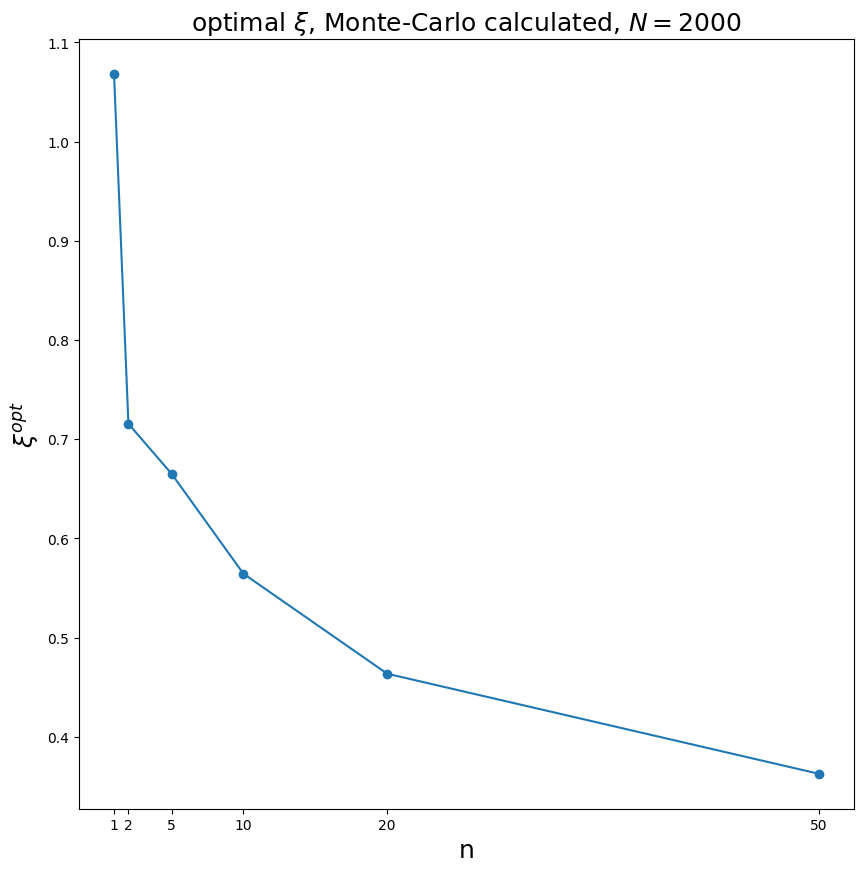

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(n, xx_opt,"-o")
ax.set_xlabel(r"n",fontsize=18)
ax.set_ylabel(r"$\xi^{opt}$",fontsize=18)
ax.set_title(r"optimal $\xi$, Monte-Carlo calculated, $N=1000$",fontsize=18)
ax.set_xticks(n)
plt.show()

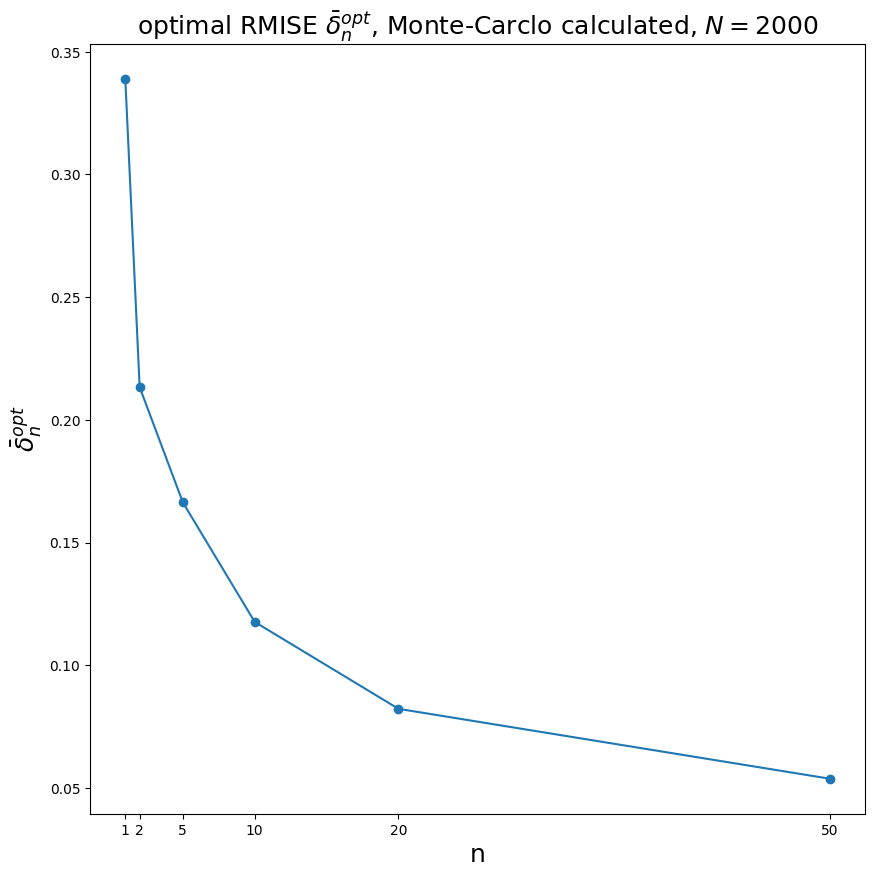

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(n, d_opt,"-o")
ax.set_xlabel(r"n",fontsize=18)
ax.set_ylabel(r"$\bar{\delta}_n^{opt}$ ",fontsize=18)
ax.set_title(r"optimal RMISE $\bar{\delta}_n^{opt}$, Monte-Carclo calculated, $N=1000$",fontsize=18)
ax.set_xticks(n)

plt.show()